In [24]:
import pandas as pd

df1 = pd.read_excel('xlsx_/nonfullDF.xlsx')
df2 = pd.read_excel('xlsx_/fulltimeDF.xlsx')

In [25]:
df1.head()

,dong,highway,ffnc,fsnc,fsc,affnc,afsnc,afsc,population
0,가락1동,0.0,0.225806,0.164634,0.000000,0.077419,0.047561,0.022764,0.299870
1,가락2동,0.0,0.161290,0.024390,0.016260,0.038710,0.056098,0.043902,0.303859
2,가락본동,0.0,0.032258,0.146341,0.154472,0.045161,0.040244,0.040650,0.426756
3,가리봉동,0.0,0.032258,0.006098,0.000000,0.283871,0.293902,0.034146,0.105551
4,가산동,0.0,1.000000,1.000000,0.065041,0.335484,0.343902,0.058537,0.549815


In [26]:
df2.head()

,dong,highway,ffnc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population
0,가락1동,0.0,0.225806,0.00,0.0,0.164634,0.000000,0.02,0.000000,0.077419,0.00,0.000000,0.047561,0.022764,0.012,0.034783,0.155581
1,가락2동,0.0,0.161290,0.00,0.0,0.024390,0.016260,0.08,0.000000,0.038710,0.01,0.033333,0.056098,0.043902,0.064,0.130435,0.154967
2,가락본동,0.0,0.032258,0.00,0.0,0.146341,0.154472,0.04,0.260870,0.045161,0.01,0.033333,0.040244,0.040650,0.064,0.078261,0.264574
3,가리봉동,0.0,0.032258,0.05,0.0,0.006098,0.000000,0.74,0.000000,0.283871,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.062857
4,가산동,0.0,1.000000,0.20,1.0,1.000000,0.065041,0.86,0.913043,0.335484,0.12,0.233333,0.343902,0.058537,0.408,0.286957,0.636785


In [27]:
import pandas as pd
import numpy as np
# population 데이터가 class값으로 들어가게 될것입니다.
# 우리는 population data를 치우치지 않게 여러 set 뽑아주는 StratifiedKFold를 하고 싶습니다.
# population을 5개의 구역으로 나눠줬습니다. kfold를 할때 각 구역에서 일정한 값들이 뽑히게 할것입니다.

# pd.cut을 이용하여 population을 5개의 구역으로 나눈것을 pop_cut이라는 column에 담았습니다,
df1["pop_cat"] = pd.cut(df1["population"],
                              bins = [0.0, 0.1, 0.2, 0.3, 0.4, 1.0],
                              labels = [1.0, 2.0, 3.0, 4.0, 5.0])

df2["pop_cat"] = pd.cut(df2["population"],
                              bins = [0.0, 0.1, 0.2, 0.3, 0.4, 1.0],
                              labels = [1.0, 2.0, 3.0, 4.0, 5.0])


In [28]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

# seed를 정해줍니다.
seed = 100
np.random.seed(seed)
tf.random.set_seed(seed)

data = df1.values
x = data[:,1:-2].astype(float)  # feature
y = data[:,-2].astype(float)   # population
y_cat = data[:,-1].astype(float) # pop_cut

#  StratifiedKFold
n_fold = 5
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)
  
# 에러를 담기위해 먼저 빈 array를 만들었습니다.  
test_error_set = []  
train_error_set = [] 

# valiation loss가 patience만큼 반복해도 변하지 않거나 나빠지면 학습을 중단하게 설정합니다.  
# patience 조정가능!
ESC = EarlyStopping(monitor = 'val_loss', patience = 20) 

for train, test in skf.split(x,y_cat): # StratifiedKFold로 나눈 데이터 셋을 받습니다. n_fold가 5이므로 for문은 5번 돌것입니다.
  model = Sequential()
  model.add(Dense(7,input_dim = 7, activation= 'relu'))
  model.add(Dense(1,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 100, batch_size= 10, callbacks = [ESC])
  # fold별로 error를 받아줘서 위에 만든 빈 array에 담아줍니다.
  train_error = mean_squared_error(y[train], model.predict(x[train])) 
  test_error = mean_squared_error(y[test], model.predict(x[test]))
  train_error_set.append(train_error)
  test_error_set.append(test_error)
# error들의 평균과 표준편차를 구해줍니다.
average_train_error = sum(train_error_set)/5
ate1 = average_train_error*np.ones(5)
train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
average_test_error = sum(test_error_set)/5
ate2 = average_test_error*np.ones(5)
test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

print('train:',average_train_error,train_standard_deviation)
print('test:',average_test_error,test_standard_deviation)



Epoch 1/300
28/28 [==============================] - 0s 7ms/step - loss: 0.0746 - val_loss: 0.0595
Epoch 2/300
28/28 [==============================] - 0s 5ms/step - loss: 0.0593 - val_loss: 0.0493
Epoch 3/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0415
Epoch 4/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0351
Epoch 5/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.0301
Epoch 6/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0307 - val_loss: 0.0267
Epoch 7/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0271 - val_loss: 0.0239
Epoch 8/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0218
Epoch 9/300
28/28 [==============================] - 0s 5ms/step - loss: 0.0224 - val_loss: 0.0204
Epoch 10/300
28/28 [==============================] - 0s 4ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 11/

In [29]:
# 위에서 만든 모델을 바탕으로 layer 수와 node 갯수를 변수로 받는 함수를 만들어줍니다.

def construct_layer(layer_num,node_num):
  test_error_set = []  
  train_error_set = []  
  
  for train, test in skf.split(x,y_cat):
    model = Sequential()
    model.add(Dense(node_num,input_dim = 7, activation= 'relu'))
    model.add(Dense(layer_num,activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
    model.fit(x[train],y[train], validation_split= 0.2, epochs = 100, batch_size= 10, callbacks = [ESC])
    train_error = mean_squared_error(y[train], model.predict(x[train]))
    test_error = mean_squared_error(y[test], model.predict(x[test]))
    train_error_set.append(train_error)
    test_error_set.append(test_error)
  
  average_train_error = sum(train_error_set)/5
  ate1 = average_train_error*np.ones(5)
  train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
  average_test_error = sum(test_error_set)/5
  ate2 = average_test_error*np.ones(5)
  test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

  return [average_train_error, train_standard_deviation,average_test_error,test_standard_deviation]  

In [30]:
a = construct_layer(1,15)
print(a)
#결과가 list로 잘 출력이 되네요!

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0714 - val_loss: 0.0597
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0587 - val_loss: 0.0494
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0493 - val_loss: 0.0415
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0351
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0354 - val_loss: 0.0300
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0306 - val_loss: 0.0266
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0271 - val_loss: 0.0238
Epoch 8/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0217
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 11/

In [32]:
x_arr = [] # train error
y_arr = [] # test error
# hidden layer의 node수를 7로 해두고 층을 계속 쌓았을때 loss가 어떻게 변하는지 그려봅시다.
max_layer = 50
for i in range(0,max_layer):
  a = construct_layer(i,7)
  x_arr.append(a[0])
  y_arr.append(a[2])
  print('layer:',i)

Epoch 1/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0703 - val_loss: 0.0592
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0492
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.0414
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0414 - val_loss: 0.0350
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0353 - val_loss: 0.0300
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0265
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0270 - val_loss: 0.0238
Epoch 8/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0242 - val_loss: 0.0217
Epoch 9/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 10/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 11/

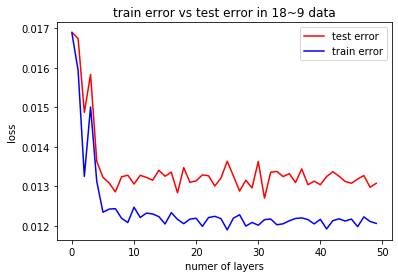

In [34]:
import matplotlib.pyplot as plt
# plot
n = np.arange(0,max_layer)
plt.plot(n,y_arr,c = 'red', label ='test error') 

plt.plot(n,x_arr,c = 'blue', label = 'train error')
plt.xlabel('numer of layers')
plt.ylabel('loss')
plt.title('train error vs test error in 18~9 data')
plt.savefig('train error vs test error')
plt.legend()

In [38]:
#
for train, test in skf.split(x,y_cat): 
  model = Sequential()
  model.add(Dense(7,input_dim = 7, activation= 'relu'))
  model.add(Dense(6,activation = 'relu'))
  model.add(Dense(5,activation = 'relu'))
  model.add(Dense(4,activation = 'relu'))
  model.add(Dense(3,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 100, batch_size= 10, callbacks = [ESC])

Epoch 1/100
28/28 [==============================] - 1s 9ms/step - loss: 0.0632 - val_loss: 0.0490
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0337 - val_loss: 0.0195
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0173
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0172
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0166 - val_loss: 0.0170
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 9/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 11/

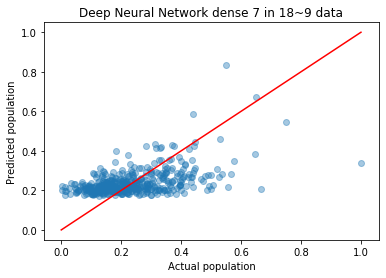

<Figure size 432x288 with 0 Axes>

In [40]:
# plot

# about last fold
# y_predict = model.predict(x[test])

# about all data
y_predict = model.predict(x) 

import matplotlib.pyplot as plt
# about last fold
# plt.scatter(y[test], y_predict, alpha=0.4)

# about all data
plt.scatter(y, y_predict, alpha=0.4)

plt.plot([0,1],[0,1], c = 'red')
plt.xlabel("Actual population")
plt.ylabel("Predicted population")
plt.title("Deep Neural Network dense 7 in 18~9 data")
plt.show()
plt.savefig('DNN_test_nonfull.png')


In [ ]:
list_y = y.tolist()
list_predicty = []
for i in range(len(list_y)):
    list_predicty.append(y_predict[i].item())

In [ ]:
diff = []
for i in range(len(list_y)):
    diff.append(list_y[i] - list_predicty[i])
diff

[0.032256134011064974,
 0.07260937194422429,
 0.1326283340613651,
 -0.10112855095742287,
 -0.03307405777865524,
 -0.02687619043646794,
 -0.037903576855405186,
 -0.08730402507323165,
 -0.19159151581345457,
 0.06864200910956653,
 0.03132184331911503,
 0.1973325550666723,
 0.11638247344479158,
 0.06451400608406826,
 -0.06954622101643221,
 -0.13213517151419252,
 0.012238020930084276,
 -0.054895987946581154,
 -0.08876696742306818,
 -0.0644265099338405,
 -0.025409275414614796,
 -0.05445806889386509,
 -0.02758697530531573,
 -0.050520440033471836,
 0.16684667068007564,
 0.2754992946441308,
 0.04450857934199509,
 0.08075282238140202,
 0.0661747985958609,
 -0.04680209983414693,
 -0.17569513853807264,
 -0.04671761668268806,
 0.1352992732350381,
 -0.010293528839426247,
 -0.014707236758848857,
 0.055365386016601015,
 0.07105832705573628,
 0.09355498552654523,
 0.02913561559543268,
 -0.010769498788477105,
 -0.005623732233712236,
 -0.02952731105855419,
 -0.0890369655206539,
 -0.09006236489223282,
 0.

In [ ]:
test_df = df1

In [ ]:
test_df['diff'] = diff

In [ ]:
test_df.head()

,dong,highway,ffnc,fsnc,fsc,affnc,afsnc,afsc,population,pop_cat,diff
0,가락1동,0.0,0.225806,0.164634,0.000000,0.077419,0.047561,0.022764,0.299870,3.0,0.032256
1,가락2동,0.0,0.161290,0.024390,0.016260,0.038710,0.056098,0.043902,0.303859,4.0,0.072609
2,가락본동,0.0,0.032258,0.146341,0.154472,0.045161,0.040244,0.040650,0.426756,5.0,0.132628
3,가리봉동,0.0,0.032258,0.006098,0.000000,0.283871,0.293902,0.034146,0.105551,2.0,-0.101129
4,가산동,0.0,1.000000,1.000000,0.065041,0.335484,0.343902,0.058537,0.549815,5.0,-0.033074


In [ ]:
test_df.to_excel('xlsx_/dfPlusDiff(real).xlsx', index=False)

In [ ]:
test_df.sort_values(by=['diff'], axis=0, ascending=False)
test_df.to_excel('xlsx_/dfPlusDiff(real)(ver.order).xlsx', index=False)

In [ ]:
# 위에는 nonfullDF
# 아래는 full

In [ ]:
df2

,dong,highway,ffnc,nfnc,nfc,fsnc,fsc,nsnc,nsc,affnc,anfnc,anfc,afsnc,afsc,ansnc,ansc,population,pop_cat
0,가락1동,0.0,0.225806,0.00,0.000000,0.164634,0.000000,0.02,0.000000,0.077419,0.00,0.000000,0.047561,0.022764,0.012,0.034783,0.155581,2.0
1,가락2동,0.0,0.161290,0.00,0.000000,0.024390,0.016260,0.08,0.000000,0.038710,0.01,0.033333,0.056098,0.043902,0.064,0.130435,0.154967,2.0
2,가락본동,0.0,0.032258,0.00,0.000000,0.146341,0.154472,0.04,0.260870,0.045161,0.01,0.033333,0.040244,0.040650,0.064,0.078261,0.264574,3.0
3,가리봉동,0.0,0.032258,0.05,0.000000,0.006098,0.000000,0.74,0.000000,0.283871,0.08,0.233333,0.293902,0.034146,0.392,0.234783,0.062857,1.0
4,가산동,0.0,1.000000,0.20,1.000000,1.000000,0.065041,0.86,0.913043,0.335484,0.12,0.233333,0.343902,0.058537,0.408,0.286957,0.636785,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,효창동,0.0,0.000000,0.00,0.000000,0.073171,0.056911,0.00,0.086957,0.025806,0.00,0.000000,0.067073,0.060163,0.032,0.208696,0.041038,1.0
420,후암동,0.0,0.000000,0.00,0.000000,0.030488,0.000000,0.00,0.043478,0.051613,0.08,0.000000,0.029268,0.024390,0.040,0.026087,0.062667,1.0
421,휘경1동,0.0,0.000000,0.00,0.000000,0.042683,0.024390,0.00,1.000000,0.038710,0.07,0.033333,0.053659,0.099187,0.016,0.234783,0.093562,1.0
422,휘경2동,0.0,0.096774,0.10,0.166667,0.030488,0.073171,0.04,0.173913,0.032258,0.05,0.033333,0.064634,0.091057,0.024,0.286957,0.093976,1.0


In [ ]:

# seed를 정해줍니다.
seed = 90
np.random.seed(seed)
tf.random.set_seed(seed)

data = df2.values
x = data[:,1:-2].astype(float)  # feature
y = data[:,-2].astype(float)   # population
y_cat = data[:,-1].astype(float) # pop_cut

#  StratifiedKFold
n_fold = 5
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

# 에러를 담기위해 먼저 빈 array를 만들었습니다.  
test_error_set = []  
train_error_set = [] 

# valiation loss가 patience만큼 반복해도 변하지 않거나 나빠지면 학습을 중단하게 설정합니다.  
# patience 조정가능!
ESC = EarlyStopping(monitor = 'val_loss', patience = 20) 

for train, test in skf.split(x,y_cat): # StratifiedKFold로 나눈 데이터 셋을 받습니다. n_fold가 5이므로 for문은 5번 돌것입니다.
  model = Sequential()
  model.add(Dense(15,input_dim = 15, activation= 'relu'))
  model.add(Dense(8,activation = 'relu'))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
  model.fit(x[train],y[train], validation_split= 0.2, epochs = 300, batch_size= 10, callbacks = [ESC])
  # fold별로 error를 받아줘서 위에 만든 빈 array에 담아줍니다.
  train_error = mean_squared_error(y[train], model.predict(x[train])) 
  test_error = mean_squared_error(y[test], model.predict(x[test]))
  train_error_set.append(train_error)
  test_error_set.append(test_error)
# error들의 평균과 표준편차를 구해줍니다.
average_train_error = sum(train_error_set)/5
ate1 = average_train_error*np.ones(5)
train_standard_deviation = np.sqrt(sum((train_error_set - ate1)**2)/5)
average_test_error = sum(test_error_set)/5
ate2 = average_test_error*np.ones(5)
test_standard_deviation = np.sqrt(sum((test_error_set - ate2)**2)/5)

print('train:',average_train_error,train_standard_deviation)
print('test:',average_test_error,test_standard_deviation)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').